In [ ]:
pip install qiskit

In [ ]:
pip install quantuminspire

In [ ]:
pip install qiskit_nature

In [ ]:
pip install PySCF

In [ ]:
from getpass import getpass
from quantuminspire.qiskit import QI
from qiskit import Aer

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler

from qiskit.utils import QuantumInstance

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE

from functools import partial as apply_variation_to_atom_pair
import numpy as np
import matplotlib.pyplot as plt



---
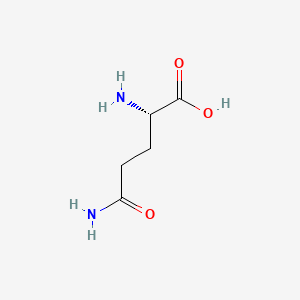

Glutamine molecule is the key protease in SARS-Cov-2. To simulate the whole molecule, 40+ qubits and several weeks of computation time would be required -- unfeasible with current technology. 

However, by reducing the glutamine to NH₂CH₃, we are able to simulate the binding of glutamine with a protease inhibitor, effectively achieving a speedup in the development of new SARS-Cov-2 vaccines.

*National Center for Biotechnology Information. "PubChem Compound Summary for CID 5961, Glutamine" PubChem, https://pubchem.ncbi.nlm.nih.gov/compound/Glutamine. Accessed 30 January, 2022.*


In [ ]:
# Not used, but shown to demonstrate size difference
glutamine_molecule = Molecule(geometry=
                              [['O', [-2.1389, 1.637, 0.5099]],
                               ['O', [-2.6773, 0.2475, -1.1973]],
                               ['O', [2.9039, 0.2551, 1.0351]],
                               ['N', [-1.4789,  -1.8922, -0.0291]],
                               ['N', [3.2441, 0.1932, -1.2385]],
                               ['C', [0.1338, -0.2355, 0.8758]],
                               ['C', [-1.3424, -0.6086, 0.659]],
                               ['C', [1.0032,  -0.1458, -0.3839]],
                               ['C', [-2.1158, 0.4356, -0.1257]],
                               ['C', [2.4683, 0.1136, -0.1257]],
                               ['H', [0.1904, 0.7236, -0.1051]],
                               ['H', [0.5783, -0.9764, 1.4071]],
                               ['H', [-0.18319, -0.7041, 1.5545]],
                               ['H', [0.95,-1.0821, -0.9509]],
                               ['H', [0.6339, 0.6568,-1.0331]],
                               ['H', [-1.136,-1.8186,-0.9858]],
                               ['H', [-2.4648,-2.142,-0.0988]],
                               ['H', [2.856,0.078,-2.1693]],
                               ['H', [4.2414,0.3697,-1.1781]],
                               ['H', [-2.645,2.3081,0.0041]],
                               ['C', [-1.600, -1.6000, -0.0291]]], # Carbon inhibitor
                              charge=0, multiplicity=1)

 **NH₂CH₃**

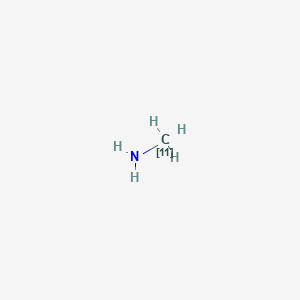

*National Center for Biotechnology Information. "PubChem Compound Summary for CID 450541, (111C)methanamine" PubChem, https://pubchem.ncbi.nlm.nih.gov/compound/111C_methanamine. Accessed 30 January, 2022.*

In [ ]:
# Toy protease derived from glutamine
toy_glutamine = Molecule(geometry=
                        [['N', [-0.7154, 0, 0]],
                         ['C', [0.7154, 0, 0,]],
                         ['H', [1.1069, 0.0916, 1.0174]],
                         ['H', [1.0996, 0.8349, -0.593]],
                         ['H', [1.0996, -0.9274, -0.4345]],
                         ['H', [-1.0625, 0.8564, 0.4294]],
                         ['H', [-1.0625, -0.7661, 0.5753]],
                         ['C', [-0.5000, 0, 0]]], # Carbon inhibitor
                          charge=0, multiplicity=1)

In [ ]:
def get_authentication():
    """Gets the authentication for connecting to the
       Quantum Inspire API.
    """
    print('Enter email:')
    email = input()
    print('Enter password')
    password = getpass()
    return email, password 

In [ ]:
if __name__ == '__main__':
    if 'authentication' not in vars().keys():
        authentication = get_authentication()
    QI.set_authentication_details(*authentication)
    backend = QI.get_backend('QX-34-L')

Both a chemistry and hardware inspired are viable options, however we have used hardware inspired trial in order to better process it on quantum hardware

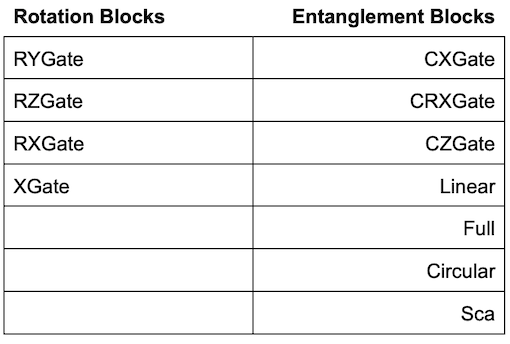

In [ ]:
num_electrons = 2
num_molecular_orbitals = 2
pertubation_steps = np.linespace(-1, 1, 4)

# Driver
molecular_orbital_maker = PySCFDriver(toy_glutamine, unit=UnitsType.ANGSTROM, basis="sto3g")

# Transformer
split_into_classical_and_quantum = ActiveSpaceTransformer(num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals)

# Construct hamiltonian and mapper
fermionic_hamiltonian = ElectronicStructureProblem(molecular_orbital_maker, [split_into_classical_and_quantum])
map_fermions_to_qubits = QubitConverter(JordanWignerMapper())

hardware_inspired_trial = TwoLocal(
                rotation_blocks=["ry"],
                entanglement_blocks="cz",
                entanglement="linear",
                reps=5)

# Solve using VQE
noise_free_quantum_environment = QuantumInstance(backend)
solver = VQE(ansatz=hardware_inspired_trial, quantum_instance=noise_free_quantum_environment)

ground_state = GroundStateEigensolver(map_fermions_to_qubits, solver)

# Process results
energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)
energy_surface_result = energy_surface.sample(fermionic_hamiltonian, pertubation_steps)

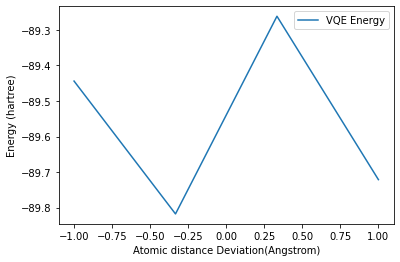

In [ ]:
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:
        plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
        plt.xlabel('Atomic distance Deviation(Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    
plot_energy_landscape(energy_surface_result)